In [82]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import string
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
sw = stopwords.words('english')

In [18]:
tweets = pd.read_csv('data/tweet_tweet.csv')
tweets.shape

(9093, 3)

In [19]:
tweets.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [20]:
tweets.rename(
    columns={
        'tweet_text': 'body',
        'emotion_in_tweet_is_directed_at': 'product',
        'is_there_an_emotion_directed_at_a_brand_or_product': 'target'
    },
    inplace=True
)

In [21]:
tweets.head()

,body,product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Building a Binary target

In [22]:
binary_df = tweets.copy()

In [23]:
binary_df

,body,product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [24]:
binary_df.iloc[3]

body       @sxsw I hope this year's festival isn't as cra...
product                                   iPad or iPhone App
target                                      Negative emotion
Name: 3, dtype: object

In [25]:
binary_df['target'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: target, dtype: int64

In [26]:
binary_df['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

Of the 9,000 records, a majority are related to Apple vs Google.

In [27]:
binary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   body     9092 non-null   object
 1   product  3291 non-null   object
 2   target   9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


After exploring the data, we want to fill in the product column nulls based upon the body of the tweet.

In [28]:
# binary_df['product'] = binary_df['product'].fillna(value='poop')

In [29]:
binary_df = binary_df.apply(lambda x: x.astype(str).str.lower())
binary_df['body'] = binary_df['body'].str.replace(r'[^\w\s]+', '')
binary_df['body'] = binary_df['body'].str.replace(r'\d+', '')
binary_df.body = binary_df.body.apply(lambda x: x.split())
binary_df

/var/folders/1s/6r4dxgb11_78p9zhgw3nkgj40000gn/T/ipykernel_3981/2014105837.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  binary_df['body'] = binary_df['body'].str.replace(r'[^\w\s]+', '')
/var/folders/1s/6r4dxgb11_78p9zhgw3nkgj40000gn/T/ipykernel_3981/2014105837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  binary_df['body'] = binary_df['body'].str.replace(r'\d+', '')


,body,product,target
0,"[wesley, i, have, a, g, iphone, after, hrs, tw...",iphone,negative emotion
1,"[jessedee, know, about, fludapp, awesome, ipad...",ipad or iphone app,positive emotion
2,"[swonderlin, can, not, wait, for, ipad, also, ...",ipad,positive emotion
3,"[sxsw, i, hope, this, years, festival, isnt, a...",ipad or iphone app,negative emotion
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",google,positive emotion
...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",ipad,positive emotion
9089,"[wave, buzz, rt, mention, we, interrupt, your,...",nan,no emotion toward brand or product
9090,"[googles, zeiger, a, physician, never, reporte...",nan,no emotion toward brand or product
9091,"[some, verizon, iphone, customers, complained,...",nan,no emotion toward brand or product


In [30]:
product_dict = {
    'android': 'Google',
    'google': 'Google',
    'ipads': 'Apple',
    'iphones': 'Apple',
    'apples': 'Apple',
    'androids': 'Google',
    'googles': 'Google',
    'ipad': 'Apple',
    'iphone': 'Apple',
    'apple': 'Apple',
}

In [15]:
binary_df.body[9091]

['some',
 'verizon',
 'iphone',
 'customers',
 'complained',
 'their',
 'time',
 'fell',
 'back',
 'an',
 'hour',
 'this',
 'weekend',
 'of',
 'course',
 'they',
 'were',
 'the',
 'new',
 'yorkers',
 'who',
 'attended',
 'sxsw']

#### AND THIS IS THE PART THAT DOESN'T WORK

In [21]:
print(binary_df.body.head())

0    [wesley, i, have, a, g, iphone, after, hrs, tw...
1    [jessedee, know, about, fludapp, awesome, ipad...
2    [swonderlin, can, not, wait, for, ipad, also, ...
3    [sxsw, i, hope, this, years, festival, isnt, a...
4    [sxtxstate, great, stuff, on, fri, sxsw, maris...
Name: body, dtype: object


In [19]:
binary_df.body[3]
for word in product_dict.keys():
    if word in binary_df.body[3]:
        print(product_dict[word])
    else:
        print()









Apple



In [17]:
counter = 0
binary_df['extra'] = 'poop'
for words in binary_df.body:
    for word in product_dict.keys():
        if word in words:
            binary_df['extra'].iloc[counter] = product_dict[word]
            counter += 1
#             print(product_dict[word])
#             print(counter)
            break

binary_df

,body,product,target,extra
0,"[wesley, i, have, a, g, iphone, after, hrs, tw...",iphone,negative emotion,Apple
1,"[jessedee, know, about, fludapp, awesome, ipad...",ipad or iphone app,positive emotion,Apple
2,"[swonderlin, can, not, wait, for, ipad, also, ...",ipad,positive emotion,Apple
3,"[sxsw, i, hope, this, years, festival, isnt, a...",ipad or iphone app,negative emotion,Google
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",google,positive emotion,Apple
...,...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",ipad,positive emotion,poop
9089,"[wave, buzz, rt, mention, we, interrupt, your,...",poop,no emotion toward brand or product,poop
9090,"[googles, zeiger, a, physician, never, reporte...",poop,no emotion toward brand or product,poop
9091,"[some, verizon, iphone, customers, complained,...",poop,no emotion toward brand or product,poop


In [21]:
binary_df

,body,product,target,extra
0,"[wesley, i, have, a, g, iphone, after, hrs, tw...",iphone,negative emotion,Google
1,"[jessedee, know, about, fludapp, awesome, ipad...",ipad or iphone app,positive emotion,Google
2,"[swonderlin, can, not, wait, for, ipad, also, ...",ipad,positive emotion,Google
3,"[sxsw, i, hope, this, years, festival, isnt, a...",ipad or iphone app,negative emotion,Google
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",google,positive emotion,Google
...,...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",ipad,positive emotion,Google
9089,"[wave, buzz, rt, mention, we, interrupt, your,...",poop,no emotion toward brand or product,Google
9090,"[googles, zeiger, a, physician, never, reporte...",poop,no emotion toward brand or product,Google
9091,"[some, verizon, iphone, customers, complained,...",poop,no emotion toward brand or product,Google


In [101]:
for word in product_dict.keys():
    for words in binary_df.body:
        if word in words:
            binary_df['extra'] = product_dict[word]

            


,body,product,target,extra
0,"[wesley, i, have, a, g, iphone, after, hrs, tw...",iphone,negative emotion,Google
1,"[jessedee, know, about, fludapp, awesome, ipad...",ipad or iphone app,positive emotion,Google
2,"[swonderlin, can, not, wait, for, ipad, also, ...",ipad,positive emotion,Google
3,"[sxsw, i, hope, this, years, festival, isnt, a...",ipad or iphone app,negative emotion,Google
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",google,positive emotion,Google
...,...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",ipad,positive emotion,Google
9089,"[wave, buzz, rt, mention, we, interrupt, your,...",poop,no emotion toward brand or product,Google
9090,"[googles, zeiger, a, physician, never, reporte...",poop,no emotion toward brand or product,Google
9091,"[some, verizon, iphone, customers, complained,...",poop,no emotion toward brand or product,Google


In [31]:
corpus = binary_df.dropna()
corpus.rename(
    columns={
        'product': 'company'
    },
    inplace=True
)

corpus

,body,company,target
0,"[wesley, i, have, a, g, iphone, after, hrs, tw...",iphone,negative emotion
1,"[jessedee, know, about, fludapp, awesome, ipad...",ipad or iphone app,positive emotion
2,"[swonderlin, can, not, wait, for, ipad, also, ...",ipad,positive emotion
3,"[sxsw, i, hope, this, years, festival, isnt, a...",ipad or iphone app,negative emotion
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",google,positive emotion
...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",ipad,positive emotion
9089,"[wave, buzz, rt, mention, we, interrupt, your,...",nan,no emotion toward brand or product
9090,"[googles, zeiger, a, physician, never, reporte...",nan,no emotion toward brand or product
9091,"[some, verizon, iphone, customers, complained,...",nan,no emotion toward brand or product


In [48]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)
sample_doc = tokenizer.tokenize(corpus.body[0])
print(corpus.body[0])
print(sample_doc)

.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
['wesley', 'I', 'have', 'a', 'G', 'iPhone', 'After', 'hrs', 'tweeting', 'at', 'RISE', 'Austin', 'it', 'was', 'dead', 'I', 'need', 'to', 'upgrade', 'Plugin', 'stations', 'at', 'SXSW']


Need to lowercase and strip punctuation.
Non-unique tweets, string index comparison.

In [52]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.help.upenn_tagset()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/camerontavares/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/camerontavares/nltk_data...


True

In [89]:
# making a copy, dropping nulls, reset index
corpus = tweets.copy()
corpus.dropna(inplace=True)
corpus.reset_index()
corpus

,body,product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion


In [88]:
# tokenizing with given pattern, only alpha char
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)
corpus.body = corpus.body.apply(lambda x: tokenizer.tokenize(x))

# lowercase for reasons
corpus.body = corpus.body.apply(lambda row: [x.lower() for x in row])

# POS tagging via pos_tag and custom function
corpus.body = corpus.body.apply(lambda x: pos_tag(x))

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# I heard that putting custom functions inside of list comps inside of lambdas was very pythonic
corpus.body = corpus.body.apply(lambda row: [(x[0], get_wordnet_pos(x[1])) for x in row])

corpus

,body,product,target
0,"[(wesley, n), (i, n), (have, v), (a, n), (g, n...",iPhone,Negative emotion
1,"[(jessedee, n), (know, v), (about, n), (fludap...",iPad or iPhone App,Positive emotion
2,"[(swonderlin, n), (can, n), (not, r), (wait, v...",iPad,Positive emotion
3,"[(sxsw, n), (i, n), (hope, v), (this, n), (yea...",iPad or iPhone App,Negative emotion
4,"[(sxtxstate, n), (great, a), (stuff, n), (on, ...",Google,Positive emotion
...,...,...,...
9077,"[(mention, n), (your, n), (pr, n), (guy, n), (...",iPhone,Positive emotion
9079,"[(quot, n), (papyrus, n), (sort, n), (of, n), ...",iPad,Positive emotion
9080,"[(diller, n), (says, v), (google, a), (tv, n),...",Other Google product or service,Negative emotion
9085,"[(i've, n), (always, r), (used, v), (camera, n...",iPad or iPhone App,Positive emotion


In [68]:
# lemmatizing things, for reasons
lemmatizer = nltk.stem.WordNetLemmatizer()
corpus.body = corpus.body.apply(lambda row: [lemmatizer.lemmatize(x[0]) for x in row])

#show me the money
corpus

,body,product,target
0,"[wesley, i, have, a, g, iphone, after, hr, twe...",iPhone,Negative emotion
1,"[jessedee, know, about, fludapp, awesome, ipad...",iPad or iPhone App,Positive emotion
2,"[swonderlin, can, not, wait, for, ipad, also, ...",iPad,Positive emotion
3,"[sxsw, i, hope, this, year's, festival, isn't,...",iPad or iPhone App,Negative emotion
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",Google,Positive emotion
...,...,...,...
9077,"[mention, your, pr, guy, just, convinced, me, ...",iPhone,Positive emotion
9079,"[quot, papyrus, sort, of, like, the, ipad, quo...",iPad,Positive emotion
9080,"[diller, say, google, tv, quot, might, be, run...",Other Google product or service,Negative emotion
9085,"[i've, always, used, camera, for, my, iphone, ...",iPad or iPhone App,Positive emotion


In [73]:
lemmed_bow = []
for row in corpus.body:
    for lemma in row:
        lemmed_bow.append(lemma)

print(f'There are {len(set(lemmed_bow))} unique lemmas.')

There are 5249 unique lemmas.


In [90]:
corpus.body

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9077    @mention your PR guy just convinced me to swit...
9079    &quot;papyrus...sort of like the ipad&quot; - ...
9080    Diller says Google TV &quot;might be run over ...
9085    I've always used Camera+ for my iPhone b/c it ...
9088                        Ipad everywhere. #SXSW {link}
Name: body, Length: 3291, dtype: object

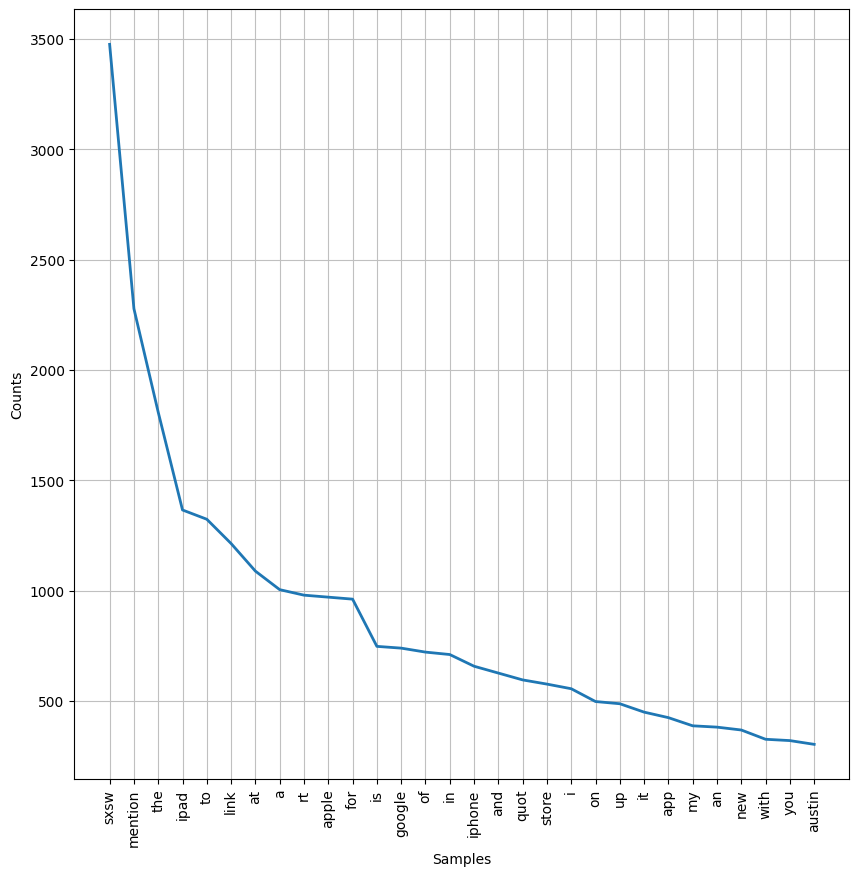

In [79]:
fdist = FreqDist(lemmed_bow)
plt.figure(figsize=(10, 10))
fdist.plot(30)
labels = len(set(lemmed_bow))
# ax = plt.gca()
# ax.set_xticklabels(labels=labels, rotation=45);

#### how pretty, a graph

In [93]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw,
                      ngram_range=[1, 2])

X = vec.fit_transform(corpus.body)

df_cv = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df_cv.head()

/opt/homebrew/Caskroom/miniforge/base/envs/m1a/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aapl,aapl knows,aapl open,aaron,aaron p,abacus,abacus phones,abandoned,abandoned reality,aber,...,zomg,zomg ipad,zomg mention,zone,zone right,zoom,zoom amp,zoom brushstroke,zzzs,zzzs iphone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
tf_vec = TfidfVectorizer(
    token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
    stop_words=sw,
)

X = tf_vec.fit_transform(corpus.body)

df_tf = pd.DataFrame(X.toarray(), columns=tf_vec.get_feature_names())
df_tf.head()

/opt/homebrew/Caskroom/miniforge/base/envs/m1a/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aapl,aaron,abacus,abandoned,aber,ability,able,abroad,absolute,absolutely,...,zimride,zing,zip,zite,zms,zombies,zomg,zone,zoom,zzzs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
df_cv.iloc[1000].sort_values(ascending=False)[:10]

austin sxsw        1
downtown austin    1
opening popup      1
popup store        1
sxsw               1
launch             1
austin             1
smart              1
link               1
opening            1
Name: 1000, dtype: int64

In [98]:
df_tf.iloc[1000].sort_values(ascending=False)[:10]

move        0.454616
smart       0.389408
popup       0.357166
downtown    0.345111
opening     0.344260
launch      0.297891
austin      0.255434
store       0.208169
apple       0.173263
link        0.150400
Name: 1000, dtype: float64

In [100]:
tf_vec.vocabulary_

{'wesley': 5327,
 'g': 1891,
 'iphone': 2510,
 'hrs': 2297,
 'tweeting': 5059,
 'rise': 4050,
 'austin': 296,
 'dead': 1159,
 'need': 3191,
 'upgrade': 5146,
 'plugin': 3601,
 'stations': 4537,
 'sxsw': 4692,
 'jessedee': 2559,
 'know': 2652,
 'fludapp': 1783,
 'awesome': 331,
 'ipad': 2504,
 'app': 198,
 'likely': 2770,
 'appreciate': 220,
 'design': 1224,
 'also': 134,
 "they're": 4856,
 'giving': 1976,
 'free': 1843,
 'ts': 5028,
 'swonderlin': 4683,
 'wait': 5258,
 'sale': 4107,
 'hope': 2270,
 "year's": 5471,
 'festival': 1714,
 'crashy': 1049,
 'sxtxstate': 4716,
 'great': 2053,
 'stuff': 4604,
 'fri': 1848,
 'marissa': 2941,
 'mayer': 2972,
 'google': 2014,
 'tim': 4901,
 "o'reilly": 3288,
 'tech': 4782,
 'books': 516,
 'conferences': 931,
 'amp': 151,
 'matt': 2965,
 'mullenweg': 3146,
 'wordpress': 5408,
 'starting': 4529,
 'ctia': 1093,
 'around': 245,
 'corner': 1003,
 'googleio': 2023,
 'hop': 2269,
 'skip': 4350,
 'jump': 2591,
 'good': 2008,
 'time': 4903,
 'android': 159